# Test 14 {#sec-test_14}
This test circuit has one unknown current source. This circuit was design to test a bug fix during generation of the A matrix where the C matrix didn't get included if there was only one unknown current.

![test circuit](test_14.png){#fig-test_14}

```
* test_14.asc
I1 1 0 1 
R1 1 0 0.05
L1 1 2 0.025
C1 2 0 0.25

```

In [1]:
#import os
from sympy import *
import numpy as np
from tabulate import tabulate
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

## Load the net list

In [2]:
net_list = '''
I1 1 0 1 
R1 1 0 0.05
L1 1 2 0.025
C1 2 0 0.25
'''

## Call the symbolic modified nodal analysis function

In [3]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

Display the equations

In [4]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

$I_{L1} + \frac{v_{1}}{R_{1}} = - I_{1}$<br>$C_{1} s v_{2} - I_{L1} = 0$<br>$- I_{L1} L_{1} s + v_{1} - v_{2} = 0$<br>

### Netlist statistics

In [5]:
print(report)

Net list report
number of lines in netlist: 4
number of branches: 4
number of nodes: 2
number of unknown currents: 1
number of RLC (passive components): 3
number of inductors: 1
number of independent voltage sources: 0
number of independent current sources: 1
number of op amps: 0
number of E - VCVS: 0
number of G - VCCS: 0
number of F - CCCS: 0
number of H - CCVS: 0
number of K - Coupled inductors: 0



### Connectivity Matrix

In [6]:
A

⎡1              ⎤
⎢──   0      1  ⎥
⎢R₁             ⎥
⎢               ⎥
⎢0   C₁⋅s   -1  ⎥
⎢               ⎥
⎣1    -1   -L₁⋅s⎦

### Unknown voltages and currents

In [7]:
X

### Known voltages and currents

In [8]:
Z

### Network dataframe

In [9]:
network_df

,element,p node,n node,cp node,cn node,Vout,value,Vname,Lname1,Lname2
0,I1,1,0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,R1,1,0,NaN,NaN,NaN,0.05,NaN,NaN,NaN
2,L1,1,2,NaN,NaN,NaN,0.025,NaN,NaN,NaN
3,C1,2,0,NaN,NaN,NaN,0.25,NaN,NaN,NaN


### Unknown current dataframe

In [10]:
i_unk_df

,element,p node,n node
0,L1,1,2


### Build the network equation matrix

In [11]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)
NE_sym

⎡            v₁      ⎤        
⎢     I_L1 + ──      ⎥   ⎡-I₁⎤
⎢            R₁      ⎥   ⎢   ⎥
⎢                    ⎥ = ⎢ 0 ⎥
⎢   C₁⋅s⋅v₂ - I_L1   ⎥   ⎢   ⎥
⎢                    ⎥   ⎣ 0 ⎦
⎣-I_L1⋅L₁⋅s + v₁ - v₂⎦        

In [12]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

## Symbolic solution

In [13]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [14]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = \frac{- C_{1} I_{1} L_{1} R_{1} s^{2} - I_{1} R_{1}}{C_{1} L_{1} s^{2} + C_{1} R_{1} s + 1}$<br>$v_{2} = - \frac{I_{1} R_{1}}{C_{1} L_{1} s^{2} + C_{1} R_{1} s + 1}$<br>$I_{L1} = - \frac{C_{1} I_{1} R_{1} s}{C_{1} L_{1} s^{2} + C_{1} R_{1} s + 1}$<br>

## Construct a dictionary of element values

In [15]:
element_values = SymMNA.get_part_values(network_df)
element_values

In [16]:
element_values

## DC operating point
Both ?



V4 and I2 are active.

In [17]:
NE = NE_sym.subs(element_values)
NE_dc = NE.subs({s:0})
NE_dc

⎡I_L1 + 20.0⋅v₁⎤   ⎡-1.0⎤
⎢              ⎥   ⎢    ⎥
⎢    -I_L1     ⎥ = ⎢ 0  ⎥
⎢              ⎥   ⎢    ⎥
⎣   v₁ - v₂    ⎦   ⎣ 0  ⎦

In [18]:
U_dc = solve(NE_dc,X)

Display the numerical solution

Six significant digits are displayed so that results can be compared to LTSpice. 

In [19]:
table_header = ['unknown', 'mag']
table_row = []

for name, value in U_dc.items():
    table_row.append([str(name),float(value)])

print(tabulate(table_row, headers=table_header,colalign = ('left','decimal'),tablefmt="simple",floatfmt=('5s','.6f')))

unknown          mag
---------  ---------
v1         -0.050000
v2         -0.050000
I_L1        0.000000


The node voltages and current through the sources are solved for. The Sympy generated solution matches the LTSpice results:
```
       --- Operating Point ---

V(1):	 -0.05	 voltage
V(2):	 -0.05	 voltage
I(C1):	 -1.25e-14	 device_current
I(L1):	 -1.24345e-14	 device_current
I(I1):	 1	 device_current
I(R1):	 -1	 device_current

```
The results from LTSpice are slightly different in some cases starting at the 2nd decimal place.

### AC analysis
Solve equations for $\omega$ equal to 1 radian per second, s = 1j.
V1 is the AC source, magnitude of 10



In [20]:
NE = NE_sym.subs(element_values)
NE_w1 = NE.subs({s:1j})
NE_w1  # display the equations

⎡    I_L1 + 20.0⋅v₁     ⎤   ⎡-1.0⎤
⎢                       ⎥   ⎢    ⎥
⎢   -I_L1 + 0.25⋅ⅈ⋅v₂   ⎥ = ⎢ 0  ⎥
⎢                       ⎥   ⎢    ⎥
⎣-0.025⋅ⅈ⋅I_L1 + v₁ - v₂⎦   ⎣ 0  ⎦

In [21]:
U_w1 = solve(NE_w1,X)

Display the numerical solution

Six significant digits are displayed so that results can be compared to LTSpice. 

In [22]:
table_header = ['unknown', 'mag','phase, deg']
table_row = []

for name, value in U_w1.items():
    table_row.append([str(name),float(abs(value)),float(arg(value)*180/np.pi)])

print(tabulate(table_row, headers=table_header,colalign = ('left','decimal','decimal'),tablefmt="simple",floatfmt=('5s','.6f','.6f')))

unknown         mag    phase, deg
---------  --------  ------------
v1         0.049996    179.279336
v2         0.050310    179.279336
I_L1       0.012578    -90.720664



```
       --- AC Analysis ---

frequency:	0.159155	Hz
V(1):	mag:   0.049996 phase:    179.279° 	voltage
V(2):	mag:  0.0503105 phase:    179.279° 	voltage
I(C1):	mag:  0.0125776 phase:   -90.7207° 	device_current
I(L1):	mag:  0.0125776 phase:   -90.7207° 	device_current
I(I1):	mag:          1 phase:          0° 	device_current
I(R1):	mag:   0.999921 phase:    179.279° 	device_current

```

### AC Sweep
Looking at node 21 voltage and comparing the results with those obtained from LTSpice. The frequency sweep is from 0.01 Hz to 1 Hz.

In [23]:
NE = NE_sym.subs(element_values)
NE

⎡    I_L1 + 20.0⋅v₁     ⎤   ⎡-1.0⎤
⎢                       ⎥   ⎢    ⎥
⎢   -I_L1 + 0.25⋅s⋅v₂   ⎥ = ⎢ 0  ⎥
⎢                       ⎥   ⎢    ⎥
⎣-0.025⋅I_L1⋅s + v₁ - v₂⎦   ⎣ 0  ⎦

In [24]:
U_ac = solve(NE,X)

### Plot the voltage at node 2

In [25]:
H = U_ac[v2]

In [26]:
H

In [27]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system = (a, b)

In [28]:
x = np.logspace(-2, 2, 400, endpoint=False)*2*np.pi
w, mag, phase = signal.bode(system, w=x) # returns: rad/s, mag in dB, phase in deg

Load the csv file of node 10 voltage over the sweep range and plot along with the results obtained from SymPy.

In [29]:
fn = 'test_14.csv' # data from LTSpice
LTSpice_data = np.genfromtxt(fn, delimiter=',',skip_header=1)

In [30]:
# initaliaze some empty arrays
frequency = np.zeros(len(LTSpice_data))
V_1 = np.zeros(len(LTSpice_data)).astype(complex)
V_2 = np.zeros(len(LTSpice_data)).astype(complex)

In [31]:
# convert the csv data to complex numbers and store in the array
for i in range(len(LTSpice_data)):
    frequency[i] = LTSpice_data[i][0]
    V_1[i] = LTSpice_data[i][1] + LTSpice_data[i][2]*1j
    V_2[i] = LTSpice_data[i][3] + LTSpice_data[i][4]*1j

Plot the results.  
Using

> np.unwrap(2 * phase) / 2) 

to keep the pahse plots the same.

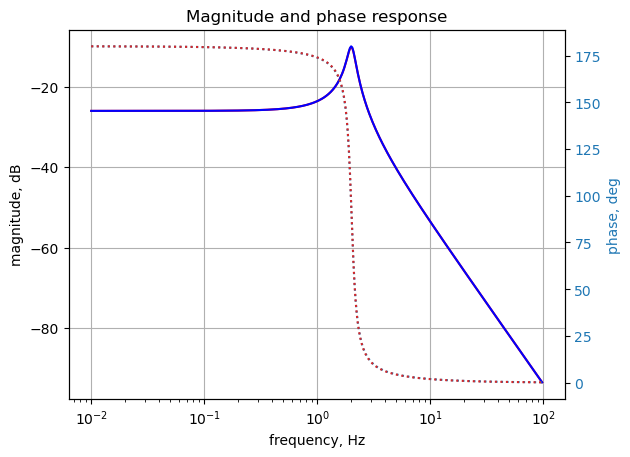

In [32]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency[0:-1], 20*np.log10(np.abs(V_2)[0:-1]),'-r')    # Bode magnitude plot
plt.semilogx(w/(2*np.pi), mag,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(frequency[0:-1], np.unwrap(2*np.angle(V_2)[0:-1]/2) *180/np.pi,':',color=color)  # Bode phase plot
plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Magnitude and phase response')
plt.show()

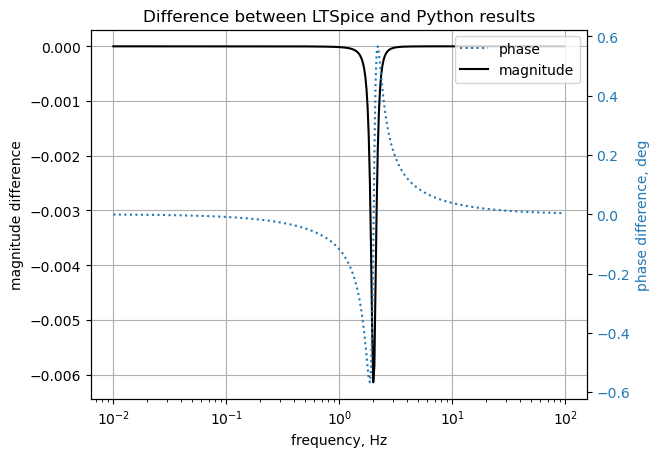

In [33]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude difference')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency[0:-1], np.abs(V_2[0:-1]) - 10**(mag/20),'-k')
#plt.semilogx(frequency[0:-1], 20*np.log10(np.abs(V_2[0:-1]))-mag,'-k')
#plt.semilogx(w/(2*np.pi), mag_v3,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(frequency[0:-1], np.angle(V_2[0:-1])*180/np.pi-phase,':',color=color,label='phase')  # Bode phase plot
#plt.semilogx(w/(2*np.pi), phase_v3,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase difference, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

ax2.plot(np.NaN, np.NaN, color='k', label='magnitude')

plt.legend()
plt.title('Difference between LTSpice and Python results')
plt.show()

The SymPy and LTSpice results have small error. 